In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import math as mt
import random 
import copy as cp

In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount = True)

Mounted at /content/drive


In [ ]:
import gensim.downloader
glove_vectors =gensim.downloader.load('glove-wiki-gigaword-300') 

[=================================================-] 99.9% 375.9/376.1MB downloaded


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

In [ ]:
data = pd.read_csv("drive/MyDrive/ProjectFiles/train.tsv" , sep= '\t')
# finding average text length to decide the length of the sequence and decide whether to truncate or append zeroes
text = data['EssayText'].tolist()
sum = 0
for essay in text : 
  sum = sum + len(essay.split())
average = int(sum/len(text))
print(average)

42


In [ ]:

dfs = []
for i in range(1,3):
  k = data.loc[data["EssaySet"] == i]
  dfs.append(k)


In [ ]:
inputs_all= [[],[]]


for df in range(len(dfs)):
  text = dfs[df]['EssayText'].tolist()
  print(len(text))

  for i in range(len(text)):
    if(i%100==0):
      print(i/100 ,"=> Done")
    res = text[i]
    res = nlp(res)
    res_tokens =[]

    # Removing stop Words and punchuations
    for token in res:
      if(token not in stop_words and token.pos_!="PUNCT" and str(token)!=''):
        res_tokens.append(token.lemma_)

    text_vectors = []
    for word in res_tokens:
      try:
        text_vectors.append(glove_vectors[str(word).lower().strip()])
      except KeyError:
        text_vectors.append([0]*300)


    # Should padd zeroes or truncate extra characters depending on the sequence length
    if(len(text_vectors) > average):
      text_vectors = text_vectors[:42]
    elif(len(text_vectors) < average):
      while len(text_vectors) < average:
        text_vectors.append(np.array([0.0] * 300))
    inputs_all[df].append(text_vectors)

  inputs_all[df] = np.array(inputs_all[df])
  print(inputs_all[df].shape)
  np.save('vector' + str(df) , inputs_all[df])

1672
0.0 => Done
1.0 => Done
2.0 => Done
3.0 => Done
4.0 => Done
5.0 => Done
6.0 => Done
7.0 => Done
8.0 => Done
9.0 => Done
10.0 => Done
11.0 => Done
12.0 => Done
13.0 => Done
14.0 => Done
15.0 => Done
16.0 => Done
(1672, 42, 300)
1278
0.0 => Done
1.0 => Done
2.0 => Done
3.0 => Done
4.0 => Done
5.0 => Done
6.0 => Done
7.0 => Done
8.0 => Done
9.0 => Done
10.0 => Done
11.0 => Done
12.0 => Done
(1278, 42, 300)


In [ ]:
import pandas as pd

data = pd.read_excel("/content/drive/MyDrive/Answer Grading/Hindi.xlsx")
dfs = []
Topics = ["Heat" , "SOUND"]
for i in Topics:
  k = data.loc[data["Topic"] == i]
  dfs.append(k)
UserAnswers = []
ProcessedAnswers =[]
Grades = []
Questions =[]

for i in range(0,2):
  UserAnswers.append(list(dfs[i]["User Answer"]))
  ProcessedAnswers.append(list(dfs[i]["Processed Answer"]))
  Questions.append(list(dfs[i]["Question"]))
  Grades.append(list(dfs[i]["Grade1"]))


In [ ]:
# train loader and test loader
from sklearn.model_selection import train_test_split

a = np.load("/content/drive/MyDrive/ProjectFiles/Embeds0.npy")
b = np.load("/content/drive/MyDrive/ProjectFiles/Embeds1.npy")
inputs_all = [a,b]

train_loaders = []
test_loaders = []
for i in range(len(dfs)):
  X_train,X_test,Y_train,Y_test = train_test_split(inputs_all[i], np.array(dfs[i]["Grade1"].tolist()) , test_size=0.2, random_state=33)

  X_train = torch.Tensor(X_train)
  X_test = torch.Tensor(X_test)
  Y_train = torch.LongTensor(Y_train)
  Y_test = torch.LongTensor(Y_test)

  train_loaders.append(torch.utils.data.DataLoader(X_train, batch_size=16, shuffle=True))
  test_loaders.append(torch.utils.data.DataLoader(X_test, batch_size=16, shuffle=True))



In [ ]:
import math
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
from torch.autograd import Variable
import matplotlib.pyplot as plt 


# changing device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPS = torch.finfo(torch.float).eps # numerical logs

class VRNN(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim, n_layers, bias=False):
        super(VRNN, self).__init__()

        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.n_layers = n_layers

        #feature-extracting transformations
        self.phi_x = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.phi_z = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU())

        #encoder
        self.enc = nn.Sequential(
            nn.Linear(h_dim + h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.enc_mean = nn.Linear(h_dim, z_dim)
        self.enc_std = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.Softplus())

        #prior
        self.prior = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.prior_mean = nn.Linear(h_dim, z_dim)
        self.prior_std = nn.Sequential(
            nn.Linear(h_dim, z_dim),
            nn.Softplus())

        #decoder
        self.dec = nn.Sequential(
            nn.Linear(h_dim + h_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU())
        self.dec_std = nn.Sequential(
            nn.Linear(h_dim, x_dim),
            nn.Softplus())
        #self.dec_mean = nn.Linear(h_dim, x_dim)
        self.dec_mean = nn.Sequential(
            nn.Linear(h_dim, x_dim),
            nn.Sigmoid())

        #recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim, n_layers, bias)


    def forward(self, x):

        all_enc_mean, all_enc_std = [], []
        all_dec_mean, all_dec_std = [], []
        kld_loss = 0
        nll_loss = 0

        h = torch.zeros(self.n_layers, x.size(1), self.h_dim, device=device)
        for t in range(x.size(0)):
            phi_x_t = self.phi_x(x[t])
            #encoder
            enc_t = self.enc(torch.cat([phi_x_t, h[-1]], 1))
            enc_mean_t = self.enc_mean(enc_t)
            enc_std_t = self.enc_std(enc_t) 
            #prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)

            #sampling and reparameterization
            z_t = self._reparameterized_sample(enc_mean_t, enc_std_t)
            phi_z_t = self.phi_z(z_t)

            #decoder
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            dec_std_t = self.dec_std(dec_t)

            #recurrence
            out, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            #computing losses
            kld_loss += self._kld_gauss(enc_mean_t, enc_std_t, prior_mean_t, prior_std_t)
            #nll_loss += self._nll_gauss(dec_mean_t, dec_std_t, x[t])
            nll_loss += self._nll_bernoulli(dec_mean_t, x[t])

            all_enc_std.append(enc_std_t)
            all_enc_mean.append(enc_mean_t)
            all_dec_mean.append(dec_mean_t)
            all_dec_std.append(dec_std_t)

        return kld_loss, nll_loss, h ,\
            (all_enc_mean, all_enc_std), \
            (all_dec_mean, all_dec_std)


    def sample(self, seq_len):

        sample = torch.zeros(seq_len, self.x_dim, device=device)

        h = torch.zeros(self.n_layers, 1, self.h_dim, device=device)
        for t in range(seq_len):

            #prior
            prior_t = self.prior(h[-1])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_std(prior_t)

            #sampling and reparameterization
            z_t = self._reparameterized_sample(prior_mean_t, prior_std_t)
            phi_z_t = self.phi_z(z_t)

            #decoder
            dec_t = self.dec(torch.cat([phi_z_t, h[-1]], 1))
            dec_mean_t = self.dec_mean(dec_t)
            #dec_std_t = self.dec_std(dec_t)

            phi_x_t = self.phi_x(dec_mean_t)

            #recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            sample[t] = dec_mean_t.data

        return sample


    def reset_parameters(self, stdv=1e-1):
        for weight in self.parameters():
            weight.data.normal_(0, stdv)


    def _init_weights(self, stdv):
        pass


    def _reparameterized_sample(self, mean, std):
        """using std to sample"""
        eps = torch.empty(size=std.size(), device=device, dtype=torch.float).normal_()
        return eps.mul(std).add_(mean)


    def _kld_gauss(self, mean_1, std_1, mean_2, std_2):
        """Using std to compute KLD"""

        kld_element =  (2 * torch.log(std_2 + EPS) - 2 * torch.log(std_1 + EPS) + 
            (std_1.pow(2) + (mean_1 - mean_2).pow(2)) /
            std_2.pow(2) - 1)
        return	0.5 * torch.sum(kld_element)


    def _nll_bernoulli(self, theta, x):
        return - (torch.sum(x*torch.log(theta + EPS) + (1-x)*torch.log(1-theta-EPS)))


    def _nll_gauss(self, mean, std, x):
        return - (torch.sum(torch.log(std + EPS) + mt.log(2*torch.pi)/2 + (x - mean).pow(2)/(2*std.pow(2))))

Train Epoch: 1 [0/1136 (0%)]	 KLD Loss: 4.529142 	 NLL Loss: 3124.398438


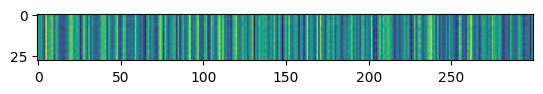

Train Epoch: 1 [160/1136 (14%)]	 KLD Loss: 0.105287 	 NLL Loss: 3110.875488


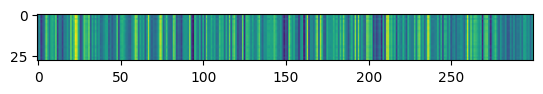

Train Epoch: 1 [320/1136 (28%)]	 KLD Loss: 0.028848 	 NLL Loss: 3110.452393


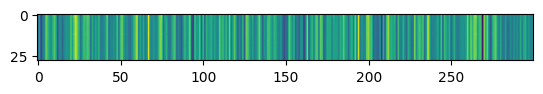

Train Epoch: 1 [480/1136 (42%)]	 KLD Loss: 0.029196 	 NLL Loss: 3110.622314


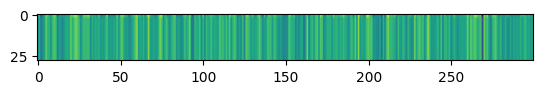

Train Epoch: 1 [640/1136 (56%)]	 KLD Loss: 0.036501 	 NLL Loss: 3108.536621


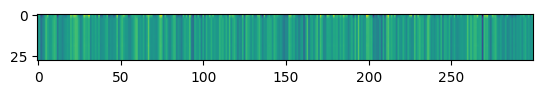

Train Epoch: 1 [800/1136 (69%)]	 KLD Loss: 0.025206 	 NLL Loss: 3096.543945


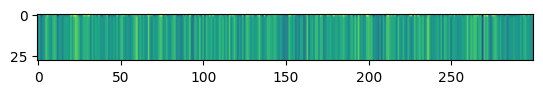

KeyboardInterrupt: ignored

In [ ]:
x_dim = 300
h_dim = 50
z_dim = 10
n_layers = 1
n_epochs = 100
clip = 10
learning_rate = 0.016
batch_size = 16
seed = 128
print_every = 10 # batches
save_every = 1 # epochs
hiddens =[]

losses = []
def train(epoch,train_loader):
    train_loss = 0
    hidden=[]
    for batch_idx,data in enumerate(train_loader):

        # transforming data
        data = data.to(device)
        data = data.squeeze().transpose(0, 1)  # (seq, batch, elem)

        """
The expression (data - data.min()) / (data.max() - data.min()) is a formula for min-max scaling or normalization. 
It is a common technique used in data preprocessing to transform data into a common scale.
        """       
        data = (data - data.min()) / (data.max() - data.min())

        """
            
transpose(0,1) is a PyTorch function that transposes a tensor. 
It swaps the first and second dimensions of a tensor. For example,
if we have a tensor x of shape (batch_size, seq_len, feature_size),
transpose(0,1) will return a tensor of shape (seq_len, batch_size, feature_size). 
This is often used in recurrent neural networks, where the sequence 
length is the first dimension and the batch size is the second dimension.
By transposing the tensor, we can feed the sequences through the 
RNN one timestep at a time while still processing all sequences in parallel.

        """

        # forward + backward + optimize
        optimizer.zero_grad()
        kld_loss, nll_loss,h, _, _ = model(data)
        hidden = h
        loss = kld_loss + nll_loss
        loss.backward()
        optimizer.step()

        # grad norm clipping, only in pytorch version >= 1.10
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # printing
        if batch_idx % print_every == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t KLD Loss: {:.6f} \t NLL Loss: {:.6f}'.format(
                epoch, batch_idx * batch_size, batch_size *
                (len(train_loader.dataset)//batch_size),
                100. * batch_idx / len(train_loader),
                kld_loss / batch_size,
                nll_loss / batch_size))

            sample = model.sample(torch.tensor(28, device=device))
            plt.imshow(sample.to(torch.device('cpu')).numpy())
            plt.pause(1e-6)

        train_loss += loss.item()
    losses.append(train_loss)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    return hidden


def test(epoch , test_loader):
    """uses test data to evaluate 
    likelihood of the model"""

    mean_kld_loss, mean_nll_loss = 0, 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):

            data = data.to(device)
            data = data.squeeze().transpose(0, 1)
            data = (data - data.min()) / (data.max() - data.min())

            """
            
transpose(0,1) is a PyTorch function that transposes a tensor. 
It swaps the first and second dimensions of a tensor. For example,
if we have a tensor x of shape (batch_size, seq_len, feature_size),
transpose(0,1) will return a tensor of shape (seq_len, batch_size, feature_size). 
This is often used in recurrent neural networks, where the sequence 
length is the first dimension and the batch size is the second dimension.
By transposing the tensor, we can feed the sequences through the 
RNN one timestep at a time while still processing all sequences in parallel.
            """

            kld_loss, nll_loss,h, _, _ = model(data)
            mean_kld_loss += kld_loss.item()
            mean_nll_loss += nll_loss.item()

    mean_kld_loss /= len(test_loader.dataset)
    mean_nll_loss /= len(test_loader.dataset)

    print('====> Test set loss: KLD Loss = {:.4f}, NLL Loss = {:.4f} '.format(
        mean_kld_loss, mean_nll_loss))



for iter in range(len(dfs)):
  hid = []
  model = VRNN(x_dim, h_dim, z_dim, n_layers)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(1, n_epochs + 1):

      # training + testing
      hid = train(epoch,train_loaders[iter])
      test(epoch,test_loaders[iter])
  hiddens.append(hid)
    # saving model
    # if epoch % save_every == 1:
    #     fn = 'saves/vrnn_state_dict_'+str(epoch)+'.pth'
    #     torch.save(model.state_dict(), fn)
    #     print('Saved model to '+fn)

print(hiddens)

In [ ]:
save_hiddens =[]

for i in range(len(hiddens)):
  h = list(hiddens[i][:,-1,:][0].detach().cpu().numpy())
  save_hiddens = save_hiddens + h

save_hiddens = np.array(save_hiddens)
np.save('hiddens' , save_hiddens)

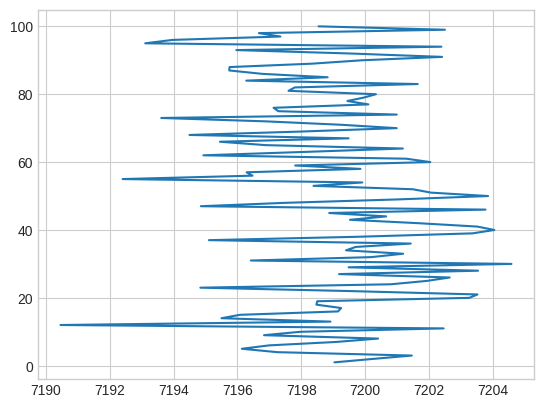

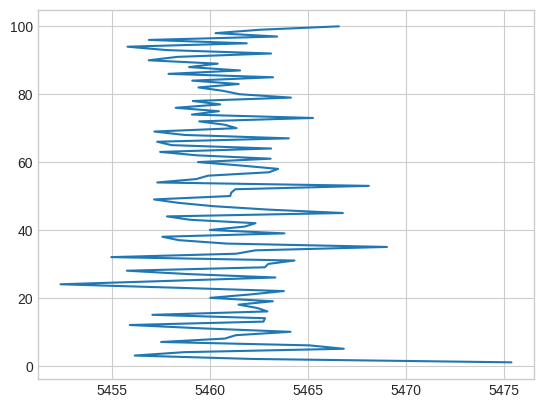

8746516.328125

In [ ]:
#plot number of epochs vs losses graph

%matplotlib inline
import matplotlib.pyplot as plt

y_axis = np.arange(1,n_epochs+1,1)
for i in range(len(losses)//n_epochs):
  x_axis = np.array(losses[i*n_epochs : (i+1)*n_epochs])/(batch_size*n_epochs)
  plt.plot(x_axis , y_axis)
  plt.show()
losses[2*n_epochs-1]


In [ ]:
losses_save = []
for i in range(len(losses)//n_epochs):
  losses_save.append(losses[(i+1)*n_epochs-1])

losses_save = np.array(losses_save)
losses_save = losses_save/(n_epochs*batch_size)
losses_save
np.save('losses_save' , losses_save)